# Quora question pairs.

In [0]:
%matplotlib inline
%tensorflow_version 1.x
from __future__ import print_function
import numpy as np
import pandas as pd
import datetime, time, json
from keras.models import Model
from keras.layers import Input, TimeDistributed, Dense, Lambda, concatenate, Dropout, BatchNormalization
from keras.layers.embeddings import Embedding
from keras.regularizers import l2
from keras.callbacks import Callback, ModelCheckpoint
from keras import backend as K
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf 
from sklearn.metrics import roc_auc_score
from keras.preprocessing.text import Tokenizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import functools
from keras import backend as K
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

In [3]:
print(tf.__version__)

1.15.0


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
question_pairs = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/capstone2/quora_questions_similarity/train.csv')
question_pairs.dropna(axis=0,
                      inplace=True)

In [6]:
question_pairs.shape

(404287, 6)

In [0]:
def classification_and_confusion_report(actual_label,predicted_label,threshold):
    ''' Compute confusion matrix and classification report for 
    given actual and predicted labels. '''
    predicted_label = np.where(predicted_label>threshold,1,0)
    report=classification_report(actual_label,predicted_label)
    cm = confusion_matrix(actual_label,predicted_label)
    print(cm)
    print(report)

In [0]:
def as_keras_metric(method):
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        ''' Wrapper for turning tensorflow metrics into keras metrics '''
        value, update_op = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update_op]):
            value = tf.identity(value)
        return value
    return wrapper

In [0]:
MAX_SEQUENCE_LENGTH=20   #The sentence length varies from 0 to 125 in question 1 and 0 to 237 in question2
                         #and the average word length is 11
NB_WORDS = 1500          #The word index length is 80904
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.1
TEST_SPLIT = 0.1
NB_EPOCHS = 10
DROPOUT = 0.1
BATCH_SIZE = 32
auc_roc = as_keras_metric(tf.metrics.auc)

In [0]:
def match_count(q1,q2):
    ''' Returns Jaccard similarity of two datasets. '''
    set_1 = set(q1)
    set_2 = set(q2)
    set_3 = set_1.intersection(set_2)
    return len(set_3)/(len(set_1)+len(set_2)-len(set_3))  

In [0]:
question_pairs.question1 = question_pairs.question1.str.lower()
question_pairs.question2 = question_pairs.question2.str.lower()

#data_obj = data.select_dtypes(['object'])  #selects the columns question1 and question2
question_pairs['char_match_count']= \
    question_pairs.apply(lambda row: match_count(row['question1'],row['question2']),
                         axis=1)
question_pairs['word_match_count'] = \
    question_pairs.apply(lambda row: match_count(row['question1'].split(),row['question2'].split()),
                         axis=1)

In [12]:
print(question_pairs['char_match_count'].head(5))
print(question_pairs['word_match_count'].head(5))

0    1.000000
1    0.703704
2    0.750000
3    0.466667
4    0.653846
Name: char_match_count, dtype: float64
0    0.769231
1    0.250000
2    0.200000
3    0.000000
4    0.111111
Name: word_match_count, dtype: float64


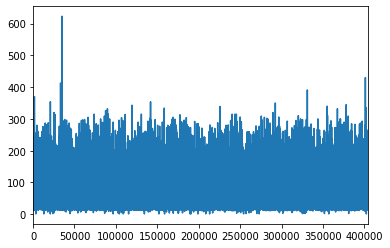

In [13]:
question_pairs.question1.str.len().plot()

In [14]:
question_pairs.question1.head(5)

0    what is the step by step guide to invest in sh...
1    what is the story of kohinoor (koh-i-noor) dia...
2    how can i increase the speed of my internet co...
3    why am i mentally very lonely? how can i solve...
4    which one dissolve in water quikly sugar, salt...
Name: question1, dtype: object

In [0]:
import re, math
from collections import Counter

def get_cosine(vec1, vec2):
    ''' Calculate cosine similarity between two vectors,
    each vector is dictionary with key and value word:count.'''
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])

    sum1 = sum([vec1[x]**2 for x in vec1.keys()])
    sum2 = sum([vec2[x]**2 for x in vec2.keys()])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)

    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator

def text_to_vector(text):
    words = re.compile(r'\w+').findall(text)
    return Counter(words)

In [0]:
question_pairs['cosine_similarity']= \
    question_pairs.apply(lambda row: get_cosine(text_to_vector(row['question1']),
                                       text_to_vector(row['question2'])),
                         axis=1)

In [17]:
question_pairs.head(10)

,id,qid1,qid2,question1,question2,is_duplicate,char_match_count,word_match_count,cosine_similarity
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1.000000,0.769231,0.944911
1,1,3,4,what is the story of kohinoor (koh-i-noor) dia...,what would happen if the indian government sto...,0,0.703704,0.250000,0.613572
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,0.750000,0.200000,0.338062
3,3,7,8,why am i mentally very lonely? how can i solve...,find the remainder when [math]23^{24}[/math] i...,0,0.466667,0.000000,0.000000
4,4,9,10,"which one dissolve in water quikly sugar, salt...",which fish would survive in salt water?,0,0.653846,0.111111,0.419314
5,5,11,12,astrology: i am a capricorn sun cap moon and c...,"i'm a triple capricorn (sun, moon and ascendan...",1,0.740741,0.347826,0.631579
6,6,13,14,should i buy tiago?,what keeps childern active and far from phone ...,0,0.458333,0.000000,0.000000
7,7,15,16,how can i be a good geologist?,what should i do to be a great geologist?,1,0.777778,0.333333,0.503953
8,8,17,18,when do you use シ instead of し?,"when do you use ""&"" instead of ""and""?",0,0.789474,0.600000,0.801784
9,9,19,20,motorola (company): can i hack my charter moto...,how do i hack motorola dcx3400 for free internet?,0,0.730769,0.200000,0.444444


#Train-test split.

In [0]:
msk = np.random.rand(len(question_pairs)) < TEST_SPLIT
train = question_pairs[~msk]
test = question_pairs[msk]

#Tokenize dataset.

In [0]:
#Only 1500 words are taken in consideration in the model.
tokenizer = Tokenizer(num_words = NB_WORDS)

#Fitting on vocabulary used in both question1 and question2.
tokenizer.fit_on_texts(np.concatenate((question_pairs.question1.astype(str), 
                                       question_pairs.question2.astype(str)),
                                      axis=0))

#Coverting texts to sequences on questions 1 and 2, in training dataset.
sequences_train_q1 = tokenizer.texts_to_sequences(train.question1.astype(str))
sequences_train_q2 = tokenizer.texts_to_sequences(train.question2.astype(str))

sequences_test_q1 = tokenizer.texts_to_sequences(test.question1.astype(str))
sequences_test_q2 = tokenizer.texts_to_sequences(test.question2.astype(str))

word_index = tokenizer.word_index

#Padding sequences.

In [0]:
sequences_train_q1_padded = pad_sequences(sequences_train_q1, maxlen=MAX_SEQUENCE_LENGTH)
sequences_train_q2_padded = pad_sequences(sequences_train_q2, maxlen=MAX_SEQUENCE_LENGTH)

sequences_test_q1_padded = pad_sequences(sequences_test_q1, maxlen=MAX_SEQUENCE_LENGTH)
sequences_test_q2_padded = pad_sequences(sequences_test_q2, maxlen=MAX_SEQUENCE_LENGTH)

In [0]:
word_embedding_matrix = np.zeros((NB_WORDS+1, EMBEDDING_DIM))

embeddings_index = {}

#Using pre-trained word vectors.
pre_trained_glove_vecs = open('/content/gdrive/My Drive/Colab Notebooks/capstone2/quora_questions_similarity/glove.6B.50d.txt',
                              encoding="utf-8")

for line in pre_trained_glove_vecs:
    values = line.split()
    word = values[0] #gives the word for which vector is given
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
    
pre_trained_glove_vecs.close()

for word, i in word_index.items():
    if i >= NB_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        word_embedding_matrix[i] = embedding_vector

In [24]:
sequences_train_q1_padded.shape

(363944, 20)

In [25]:
sequences_test_q1_padded.shape

(40343, 20)

# One shot similarity classification.

In [0]:
K.clear_session()
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import Flatten
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

question1 = Input(shape=(MAX_SEQUENCE_LENGTH,))
question2 = Input(shape=(MAX_SEQUENCE_LENGTH,))

features  = Input(shape=(3,))

q1 = Embedding(NB_WORDS + 1, 
               EMBEDDING_DIM, 
               weights=[word_embedding_matrix], 
               input_length=MAX_SEQUENCE_LENGTH, 
               trainable=True)(question1)

#q1 = Bidirectional(LSTM(30), merge_mode="sum")(q1)
q1 = TimeDistributed(Dense(EMBEDDING_DIM, activation='relu'))(q1)

q1_max_embedding_dim = Lambda(lambda x: K.max(x, axis=1), output_shape=(MAX_SEQUENCE_LENGTH, ))(q1)
q1_max_sequence_dim = Lambda(lambda x: K.max(x, axis=2), output_shape=(EMBEDDING_DIM, ))(q1)

q1_sum_embedding_dim = Lambda(lambda x: K.sum(x, axis=1), output_shape=(MAX_SEQUENCE_LENGTH, ))(q1)
q1_sum_sequence_dim = Lambda(lambda x: K.sum(x, axis=2), output_shape=(EMBEDDING_DIM, ))(q1)

q2 = Embedding(NB_WORDS + 1, 
               EMBEDDING_DIM, 
               weights=[word_embedding_matrix], 
               input_length=MAX_SEQUENCE_LENGTH, 
               trainable=True)(question2)

#q2 = Bidirectional(LSTM(30), merge_mode="sum")(q2)
q2 = TimeDistributed(Dense(EMBEDDING_DIM, activation='relu'))(q2)

q2_max_embedding_dim = Lambda(lambda x: K.max(x, axis=1), output_shape=(MAX_SEQUENCE_LENGTH, ))(q2)
q2_max_sequence_dim = Lambda(lambda x: K.sum(x, axis=2), output_shape=(EMBEDDING_DIM, ))(q2)

q2_sum_embedding_dim = Lambda(lambda x: K.sum(x, axis=1), output_shape=(MAX_SEQUENCE_LENGTH, ))(q2)
q2_sum_sequence_dim = Lambda(lambda x: K.sum(x, axis=2), output_shape=(EMBEDDING_DIM, ))(q2)

#q2 = Flatten()(q2)

#functional keras code instead of the normal sequential code
merged = concatenate([q1_max_embedding_dim,
                      q2_max_embedding_dim,
                      q1_sum_embedding_dim,
                      q2_sum_embedding_dim,
                      q1_sum_sequence_dim,
                      q2_sum_sequence_dim,
                      q1_max_sequence_dim,
                      q2_max_sequence_dim,
                      features])
merged = Dense(300, activation='relu')(merged)
merged = Dropout(0.5)(merged)
merged = BatchNormalization()(merged)
merged = Dense(100, activation='relu')(merged)
merged = Dropout(0.2)(merged)
merged = BatchNormalization()(merged)
merged = Dense(100, activation='relu')(merged)
merged = Dropout(0.2)(merged)
merged = BatchNormalization()(merged)
merged = Dense(50, activation='relu')(merged)
merged = Dropout(0.1)(merged)
merged = BatchNormalization()(merged)

is_duplicate = Dense(1, activation='sigmoid')(merged)

one_shot_model = Model(inputs=[question1,question2,features], 
                outputs=is_duplicate)

auc_roc = as_keras_metric(tf.metrics.auc)
one_shot_model.compile(loss='binary_crossentropy', 
                       optimizer='adam', 
                       metrics=[auc_roc])

In [28]:
one_shot_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 20, 50)       75050       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 20, 50)       75050       input_2[0][0]                    
____________________________________________________________________________________________

In [0]:
import keras
tbCallBack = keras.callbacks.TensorBoard(log_dir='/content/gdrive/My Drive/Colab Notebooks/capstone2/quora_questions_similarity/Graph', 
                                         histogram_freq=0,  
                                         write_graph=True, 
                                         write_images=True)

In [0]:
train_features=train[['char_match_count','word_match_count','cosine_similarity']]

In [32]:
deprecation._PRINT_DEPRECATION_WARNINGS = False
one_shot_model_history = one_shot_model.fit([sequences_train_q1_padded, sequences_train_q2_padded,train_features],
                                            train.is_duplicate,
                                            epochs=NB_EPOCHS,
                                            validation_split=VALIDATION_SPLIT,
                                            batch_size=BATCH_SIZE,
                                            callbacks=[tbCallBack],
                                            initial_epoch = 0)

Train on 327549 samples, validate on 36395 samples
Epoch 1/10
327549/327549 [==============================] - 156s 475us/step - loss: 0.5218 - auc: 0.7065 - val_loss: 0.4580 - val_auc: 0.7904

Epoch 2/10
327549/327549 [==============================] - 157s 480us/step - loss: 0.4678 - auc: 0.8073 - val_loss: 0.4432 - val_auc: 0.8177
Epoch 3/10
327549/327549 [==============================] - 161s 492us/step - loss: 0.4581 - auc: 0.8240 - val_loss: 0.4294 - val_auc: 0.8287
Epoch 4/10
327549/327549 [==============================] - 161s 493us/step - loss: 0.4530 - auc: 0.8322 - val_loss: 0.4281 - val_auc: 0.8351
Epoch 5/10
327549/327549 [==============================] - 162s 495us/step - loss: 0.4488 - auc: 0.8374 - val_loss: 0.4227 - val_auc: 0.8394
Epoch 6/10
327549/327549 [==============================] - 162s 493us/step - loss: 0.4460 - auc: 0.8412 - val_loss: 0.4314 - val_auc: 0.8426
Epoch 7/10
327549/327549 [==============================] - 162s 493us/step - loss: 0.4442 - auc

In [0]:
import matplotlib.pyplot as plt
def plot_train_valid(model_history):
    hist = model_history.history
    x_arr = np.arange(len(hist['loss'])) + 1

    fig = plt.figure(figsize=(16, 6))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
    ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Loss', size=15)

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, hist['auc'], '-o', label='Train acc.')
    ax.plot(x_arr, hist['val_auc'], '--<', label='Validation acc.')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('AUC', size=15)

    return plt.show()

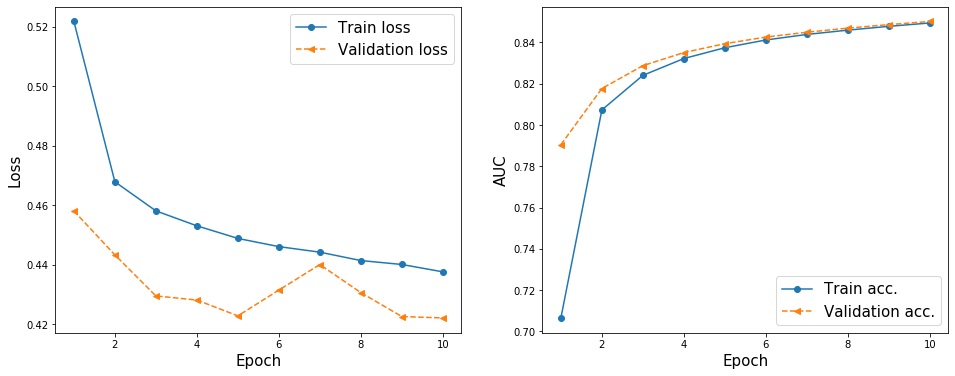

In [42]:
plot_train_valid(one_shot_model_history)

#Checking on test dataset.

In [0]:
test_data_features=test[['char_match_count','word_match_count','cosine_similarity']]
y_pred = one_shot_model.predict([sequences_test_q1_padded, 
                                 sequences_test_q2_padded,
                                 test_data_features])

In [45]:
classification_and_confusion_report(test.is_duplicate,y_pred,0.5)

[[20476  4818]
 [ 3819 11230]]
              precision    recall  f1-score   support

           0       0.84      0.81      0.83     25294
           1       0.70      0.75      0.72     15049

    accuracy                           0.79     40343
   macro avg       0.77      0.78      0.77     40343
weighted avg       0.79      0.79      0.79     40343

